<a href="https://colab.research.google.com/github/fadzie01/FadzieDocs/blob/main/sales_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TURNALL HOLDINGS LIMITED SALES FORECAST MODEL

---


###IMPORTING DATA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Turnall_Project/Sales_perday.csv')

In [ ]:
df.head(11)

,date,sales
0,12/30/2019,29632.93
1,12/31/2019,39231.30
2,1/2/2020,24588.15
3,1/3/2020,12464.45
4,1/4/2020,417.77
5,1/6/2020,9576.58
6,1/7/2020,27832.09
7,1/8/2020,35394.09
8,1/9/2020,31540.35
9,1/10/2020,18289.96


In [ ]:
df['sales'].describe()

count    9.400000e+02
mean     3.843708e+04
std      5.761935e+04
min      3.564000e+01
25%      1.389198e+04
50%      2.691532e+04
75%      4.932149e+04
max      1.160224e+06
Name: sales, dtype: float64

Choosing to work with Amounts sold per day as there are less zero values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 940 entries, 0 to 939
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    940 non-null    object 
 1   sales   940 non-null    float64
dtypes: float64(1), object(1)
memory usage: 14.8+ KB


Setting Posting date as index

In [ ]:
df_P = df.set_index('date')
df_P.head(11)

,sales
date,
12/30/2019,29632.93
12/31/2019,39231.30
1/2/2020,24588.15
1/3/2020,12464.45
1/4/2020,417.77
1/6/2020,9576.58
1/7/2020,27832.09
1/8/2020,35394.09
1/9/2020,31540.35


In [ ]:
df_P.index = pd.to_datetime(df_P.index)

In [ ]:
df_P.sort_index()

,sales
date,
2019-12-30,29632.93
2019-12-31,39231.30
2020-01-02,24588.15
2020-01-03,12464.45
2020-01-04,417.77
...,...
2023-04-25,53374.86
2023-04-26,44346.16
2023-04-27,47247.74


#####Data Filtering

In [ ]:
df_P.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 940 entries, 2019-12-30 to 2023-04-29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   940 non-null    float64
dtypes: float64(1)
memory usage: 14.7 KB


no null values

####VISUALIZATIONS

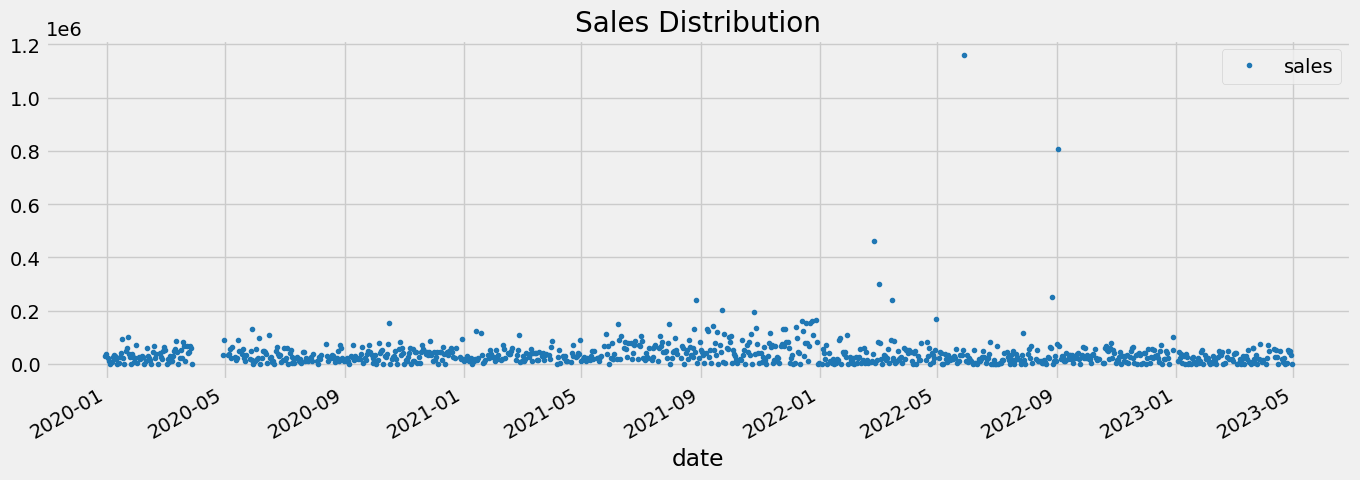

In [ ]:

df_P.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Sales Distribution')
plt.show()

Identifying Outliers

<Axes: title={'center': 'Outliers'}, xlabel='date'>

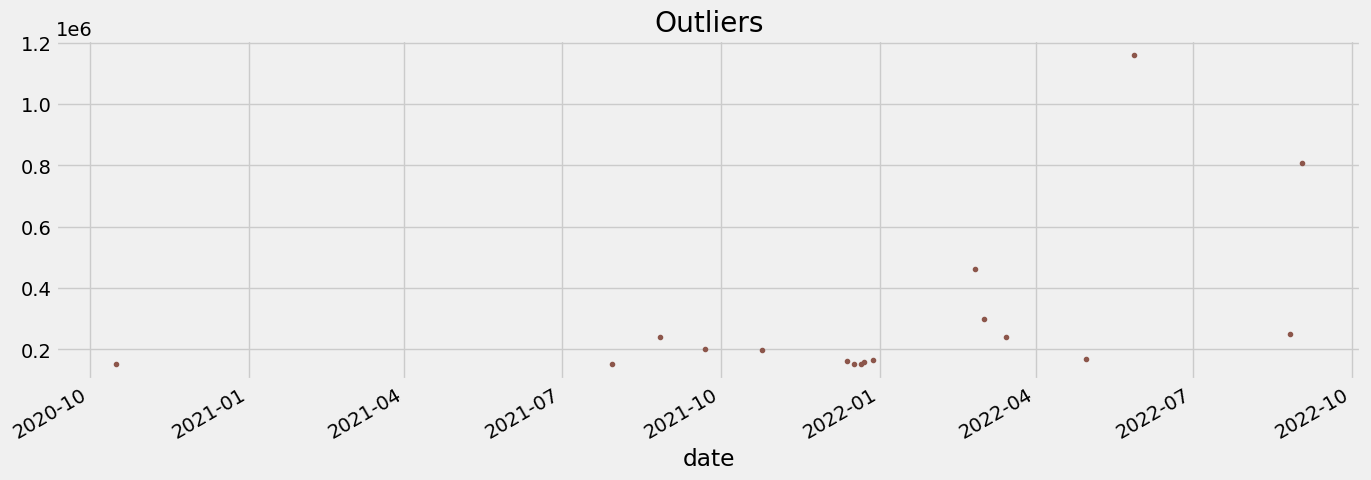

In [ ]:
df_P.query('sales > 150_000')['sales'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

Isolating Outliers

In [ ]:
df_V = df_P.query('sales < 150_000').copy()
df_V = df_V.loc[df_V.index > '05-01-2020']


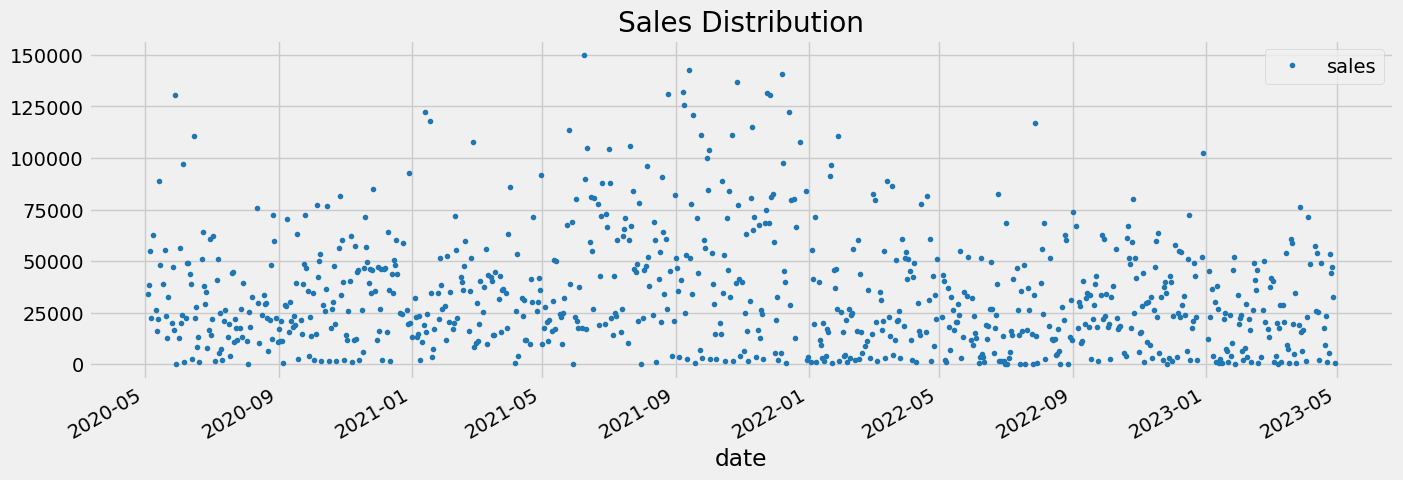

In [ ]:
df_V.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Sales Distribution')
plt.show()

In [ ]:
#df_V = df_V.loc[df_V.index > '05-01-2020']

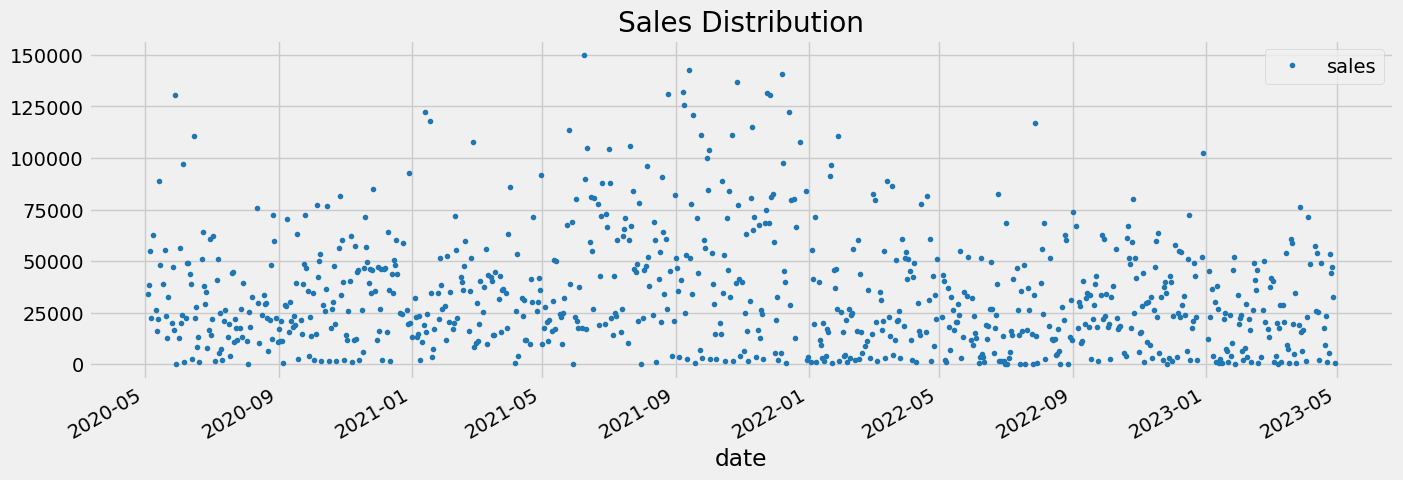

In [ ]:
df_V.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Sales Distribution')
plt.show()

###TRAINING THE MODEL

Splitting The Data

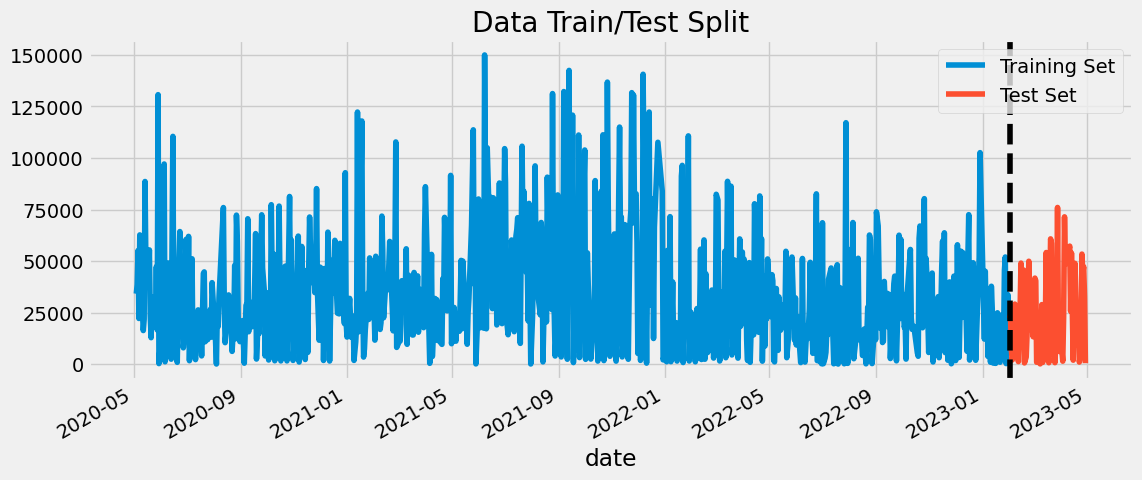

In [ ]:
train = df_V.loc[df_V.index < '02-01-2023']
test = df_V.loc[df_V.index >= '02-01-2023']

fig, ax = plt.subplots(figsize=(12, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('02-01-2023', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=4, test_size= 88, gap=1)
df_V = df_V.sort_index()



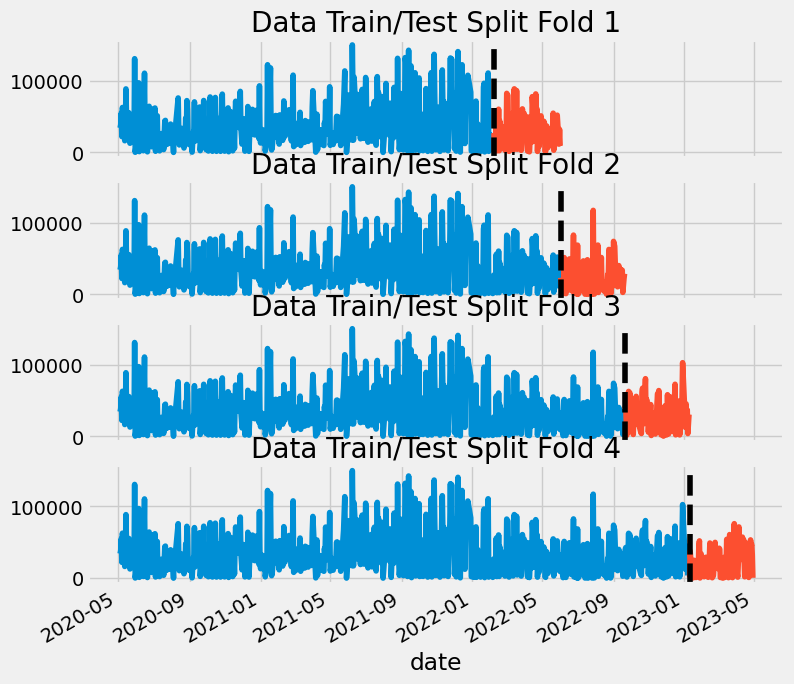

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(8, 8), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df_V):
    train = df_V.iloc[train_idx]
    test = df_V.iloc[val_idx]
    train['sales'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold+1}')
    test['sales'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

Creating Features of the dataset

In [ ]:
df = df_V
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [ ]:
def add_lags(df):
    target_map = df['sales'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('84 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('168 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('336 days')).map(target_map)
    return df

Adding Lag Features

In [ ]:
df_new= add_lags(df)

In [ ]:
df_new.head(11)

,sales,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
date,,,,,,,,,,
2020-05-04,34191.05,2,5,2020,125,4,19,NaN,NaN,NaN
2020-05-05,38572.66,2,5,2020,126,5,19,NaN,NaN,NaN
2020-05-06,55081.12,2,5,2020,127,6,19,NaN,NaN,NaN
2020-05-07,22140.54,2,5,2020,128,7,19,NaN,NaN,NaN
2020-05-08,62693.82,2,5,2020,129,8,19,NaN,NaN,NaN
2020-05-11,26420.76,2,5,2020,132,11,20,NaN,NaN,NaN
2020-05-12,16288.61,2,5,2020,133,12,20,NaN,NaN,NaN
2020-05-13,21764.28,2,5,2020,134,13,20,NaN,NaN,NaN
2020-05-14,88601.65,2,5,2020,135,14,20,NaN,NaN,NaN


In [ ]:
df_new.tail(11)

,sales,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
date,,,,,,,,,,
2023-04-17,48896.71,2,4,2023,107,17,16,23876.71,5654.58,20254.75
2023-04-19,17367.92,2,4,2023,109,19,16,10397.54,15541.51,29003.53
2023-04-20,9302.35,2,4,2023,110,20,16,45437.08,28101.05,23920.96
2023-04-21,23290.40,2,4,2023,111,21,16,51967.96,44174.24,54743.10
2023-04-22,977.28,2,4,2023,112,22,16,254.00,1053.97,3113.83
2023-04-24,5198.02,2,4,2023,114,24,17,33672.15,29634.08,13068.43
2023-04-25,53374.86,2,4,2023,115,25,17,19592.20,10764.29,35103.54
2023-04-26,44346.16,2,4,2023,116,26,17,22206.73,30038.29,NaN
2023-04-27,47247.74,2,4,2023,117,27,17,23729.89,9370.20,33234.72


Creating The Model

In [ ]:
df = df_new
tss = TimeSeriesSplit(n_splits=3, test_size=176, gap=1)
df = df.sort_index()
from sklearn.ensemble import RandomForestRegressor


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'sales'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor()
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=True)


    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:33543.41116	validation_1-rmse:53836.37460
[1]	validation_0-rmse:28042.08908	validation_1-rmse:49351.28781
[2]	validation_0-rmse:24225.02079	validation_1-rmse:48062.96261
[3]	validation_0-rmse:21708.86692	validation_1-rmse:46852.89116
[4]	validation_0-rmse:19996.22590	validation_1-rmse:46408.13152
[5]	validation_0-rmse:18627.51491	validation_1-rmse:45308.89761
[6]	validation_0-rmse:17947.15347	validation_1-rmse:45134.78890
[7]	validation_0-rmse:17400.81532	validation_1-rmse:44416.71157
[8]	validation_0-rmse:17124.95474	validation_1-rmse:44592.00521
[9]	validation_0-rmse:16797.01733	validation_1-rmse:44300.19510
[10]	validation_0-rmse:15682.78245	validation_1-rmse:44361.15025
[11]	validation_0-rmse:15196.70880	validation_1-rmse:44274.14514
[12]	validation_0-rmse:14699.26514	validation_1-rmse:44225.83032
[13]	validation_0-rmse:14556.04176	validation_1-rmse:44266.75065
[14]	validation_0-rmse:14359.31600	validation_1-rmse:44491.17393
[15]	validation_0-rmse:14078.80133	

In [ ]:
rmsq = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmsq)

24411.628801751987


In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 35507.0874
Fold scores:[46029.10665219261, 36080.52685569933, 24411.628801751987]


Visualizing Predictions

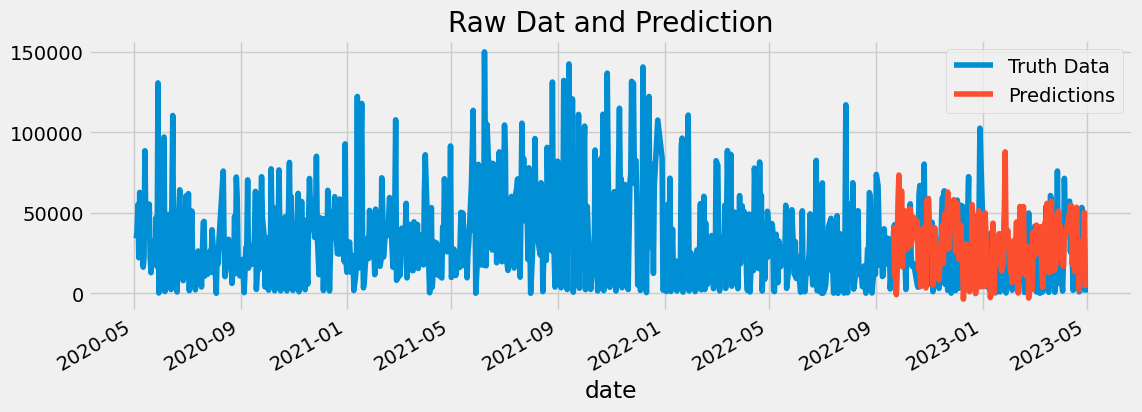

In [ ]:
test['predictions'] = y_pred
df = df.merge(test[['predictions']], how='left', left_index=True, right_index=True)
ax = df[['sales']].plot(figsize=(12, 4))
df['predictions'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

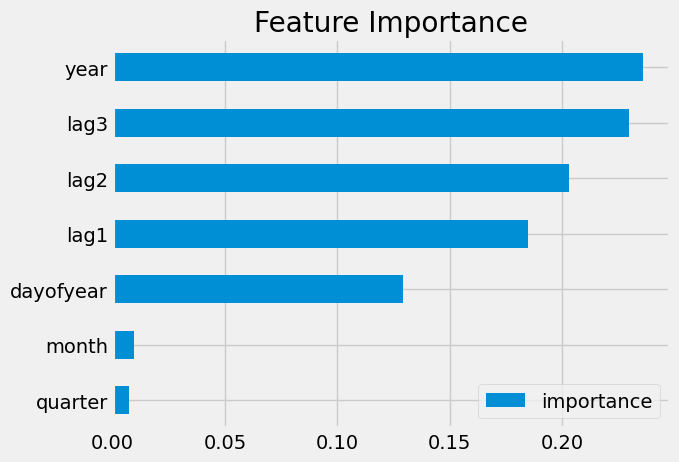

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

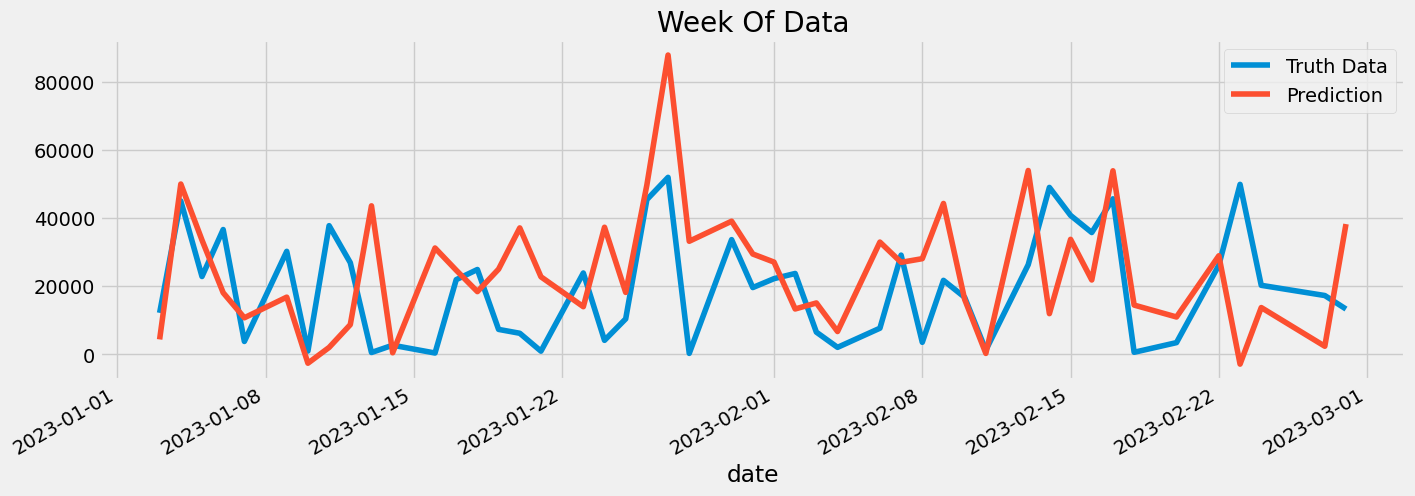

In [ ]:
ax = df.loc[(df.index > '12-31-2022') & (df.index < '03-01-2023')]['sales'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '12-31-2022') & (df.index < '03-01-2023')]['predictions'] \
    .plot(style='-')
plt.legend(['Truth Data','Prediction'])
plt.show()

Training the model with all the data for future predictions

In [ ]:
df = create_features(df)

FEATURES = ['dayofyear', 'quarter', 'month','year',
                'lag1','lag2','lag3']
TARGET = 'sales'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, colsample_bytree=1,
                       n_estimators=100,
                       learning_rate=0.3,
                       gamma=0,
                       subsample=0.75,
                       early_stopping_rounds=50,
                       max_depth=3,)

reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:35707.39581
[99]	validation_0-rmse:14736.66106


XGBRegressor(base_score=0.5, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
df.index.max()

Timestamp('2023-04-29 00:00:00')

Predicting the Future Sales

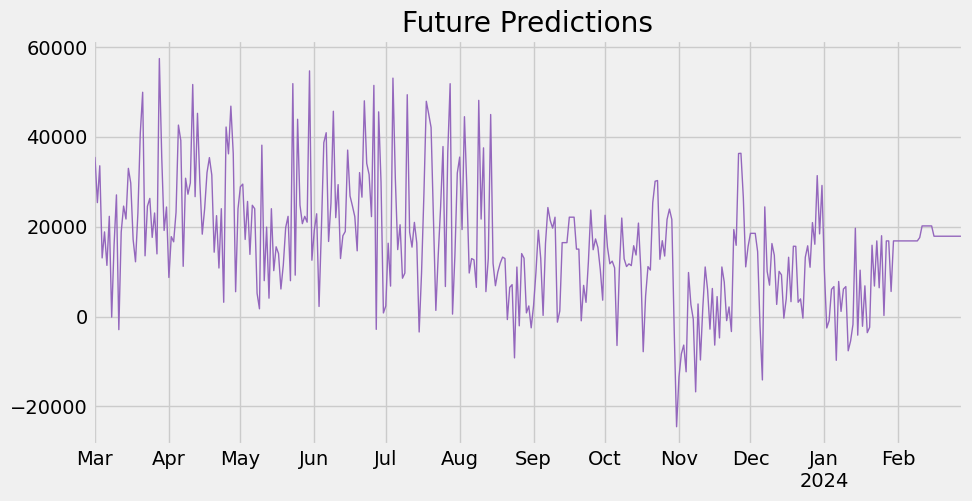

In [ ]:

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df



def add_lags(df):
    target_map = df['sales'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('84 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('168 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('336 days')).map(target_map)
    return df



future = pd.date_range('2023-02-28','2024-02-28', freq='1d')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

future_w_features = df_and_future.query('isFuture').copy()
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

#ploting prediction

future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

Downloading Model

In [ ]:
import pickle
filename = 'regX2_0'
pickle.dump(reg, open(filename, 'wb'))

Downloading Dataset

In [ ]:
df.to_csv('sales_by_price_regX10_df.csv', index=True)
